In [1]:
from pathlib import Path

from pysr import PySRRegressor

# other imports after pysr since it has to be before torch?
from jaxtyping import Float
import numpy as np
from zanj import ZANJ
import sympy as sp

from maze_dataset import MazeDatasetConfig
from maze_dataset.generation import LatticeMazeGenerators
from maze_dataset.benchmark.config_sweep import (
    SweepResult,
    full_percolation_analysis,
    dataset_success_fraction,
    plot_grouped,
)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
# magic auto-reload
%load_ext autoreload
%autoreload

tqdm_allowed_kwargs = {'mininterval', 'file', 'ascii', 'write_bytes', 'lock_args', 'unit_divisor', 'delay', 'miniters', 'unit', 'initial', 'iterable', 'unit_scale', 'maxinterval', 'disable', 'total', 'postfix', 'leave', 'smoothing', 'nrows', 'self', 'gui', 'bar_format', 'desc', 'ncols', 'dynamic_ncols', 'position', 'colour'}
mapped_kwargs = {'total': 3, 'desc': 'Processing 3 items'}


Processing 3 items: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


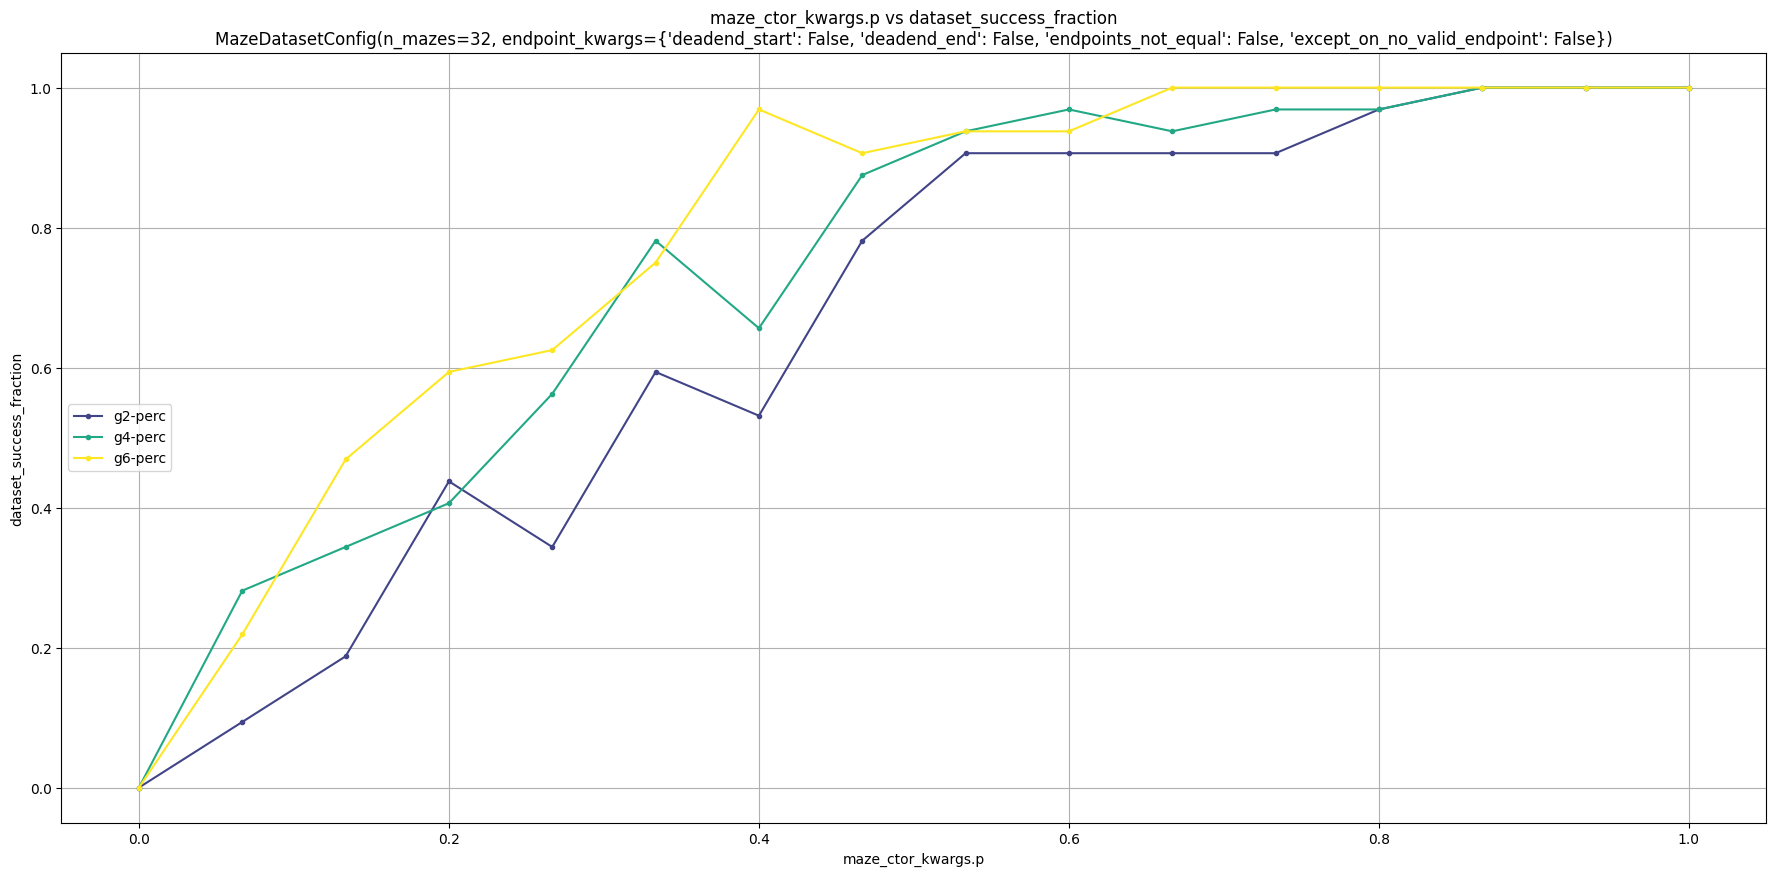

<Axes: title={'center': "maze_ctor_kwargs.p vs dataset_success_fraction\nMazeDatasetConfig(n_mazes=32, endpoint_kwargs={'deadend_start': False, 'deadend_end': False, 'endpoints_not_equal': False, 'except_on_no_valid_endpoint': False})"}, xlabel='maze_ctor_kwargs.p', ylabel='dataset_success_fraction'>

In [3]:
# Run the analysis
results: SweepResult = SweepResult.analyze(
    configs=[
        MazeDatasetConfig(
            name=f"g{grid_n}-perc",
            grid_n=grid_n,
            n_mazes=32,
            maze_ctor=LatticeMazeGenerators.gen_percolation,
            maze_ctor_kwargs=dict(),
            endpoint_kwargs=dict(
                deadend_start=False,
                deadend_end=False,
                endpoints_not_equal=False,
                except_on_no_valid_endpoint=False,
            ),
        )
        for grid_n in [2, 4, 6]
    ],
    param_values=np.linspace(0.0, 1.0, 16).tolist(),
    param_key="maze_ctor_kwargs.p",
    analyze_func=dataset_success_fraction,
    parallel=False,
)

# Plot results
results.plot(save_path=None, cfg_keys=["n_mazes", "endpoint_kwargs"])

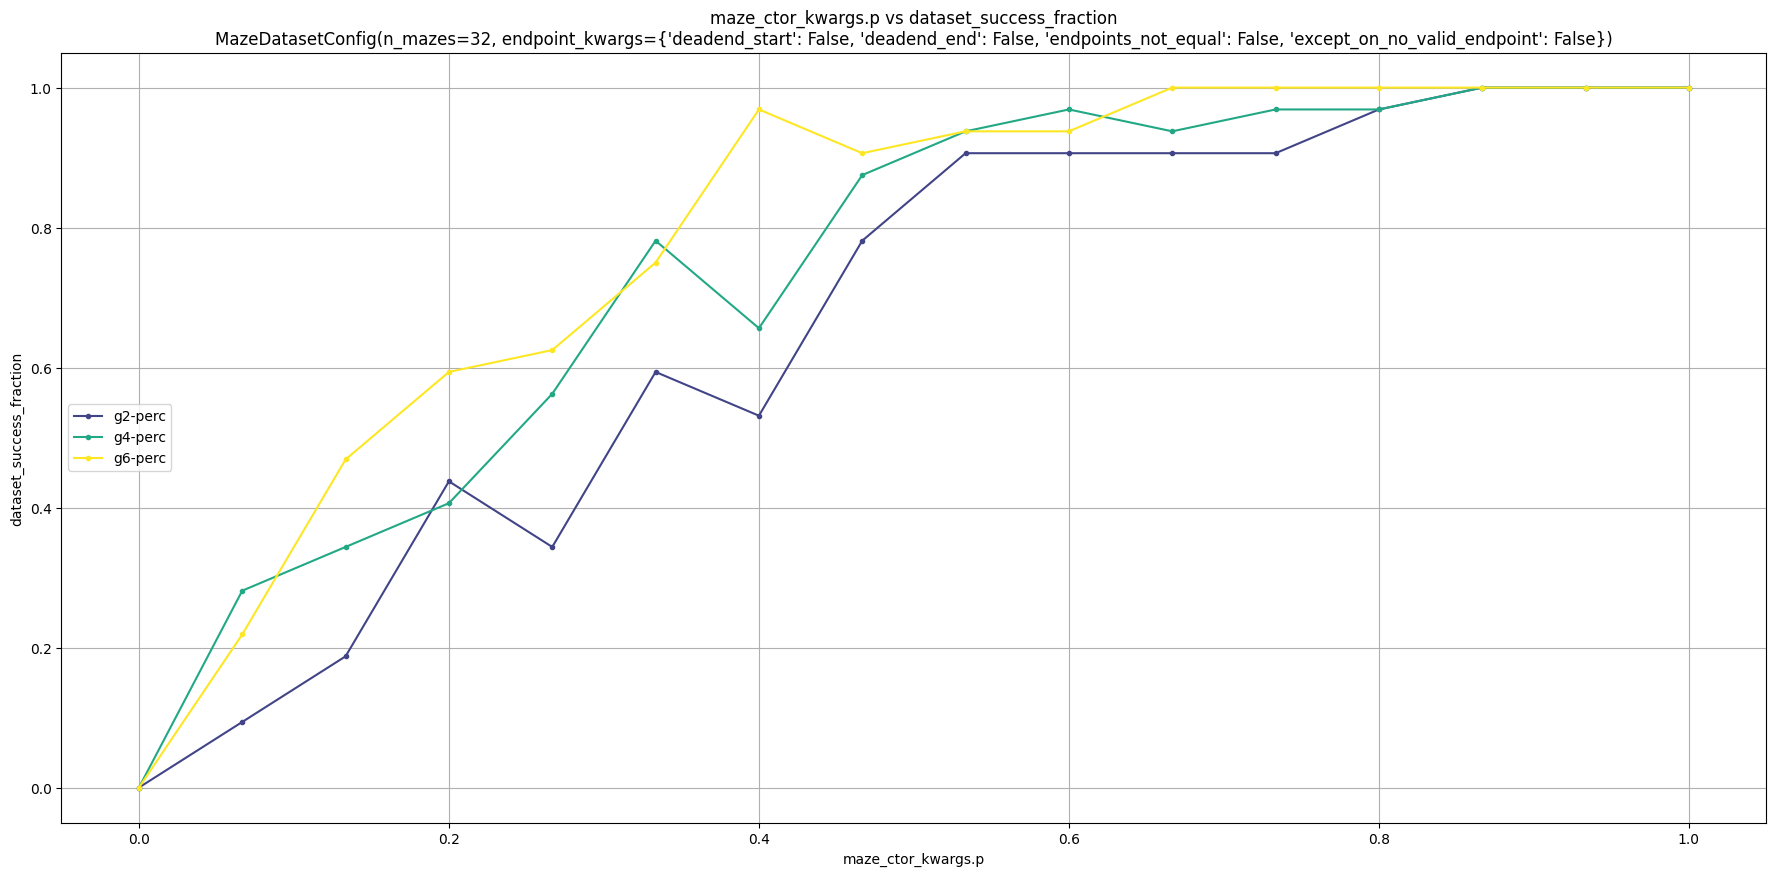

<Axes: title={'center': "maze_ctor_kwargs.p vs dataset_success_fraction\nMazeDatasetConfig(n_mazes=32, endpoint_kwargs={'deadend_start': False, 'deadend_end': False, 'endpoints_not_equal': False, 'except_on_no_valid_endpoint': False})"}, xlabel='maze_ctor_kwargs.p', ylabel='dataset_success_fraction'>

In [4]:
path = Path("../tests/_temp/dataset_frac_sweep/results_small.zanj")
results.save(path)
ZANJ().read(path).plot(cfg_keys=["n_mazes", "endpoint_kwargs"])

In [5]:
results_full: SweepResult = full_percolation_analysis(
    n_mazes=16,
    p_val_count=16,
    grid_sizes=[2, 4, 6],
    parallel=False,
)

tqdm_allowed_kwargs = {'mininterval', 'file', 'ascii', 'write_bytes', 'lock_args', 'unit_divisor', 'delay', 'miniters', 'unit', 'initial', 'iterable', 'unit_scale', 'maxinterval', 'disable', 'total', 'postfix', 'leave', 'smoothing', 'nrows', 'self', 'gui', 'bar_format', 'desc', 'ncols', 'dynamic_ncols', 'position', 'colour'}
mapped_kwargs = {'total': 18, 'desc': 'Processing 18 items'}


Processing 18 items: 100%|██████████| 18/18 [00:11<00:00,  1.51it/s]


Saving results to ../docs/benchmarks/percolation_fractions/result-n16-c18-p16.zanj


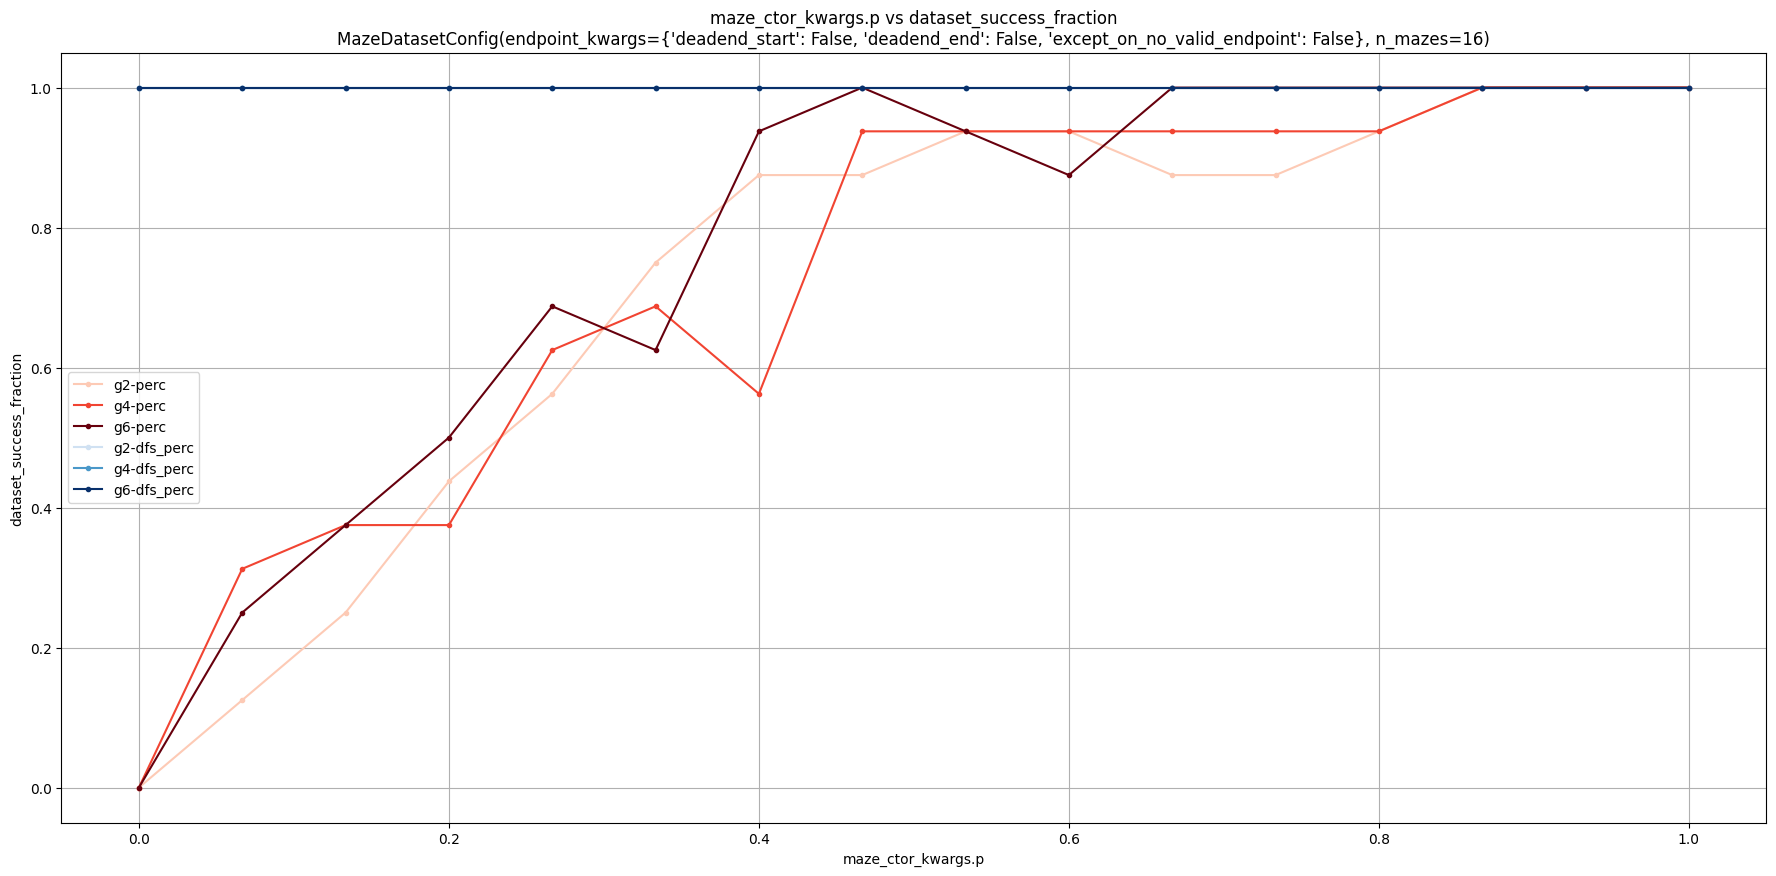

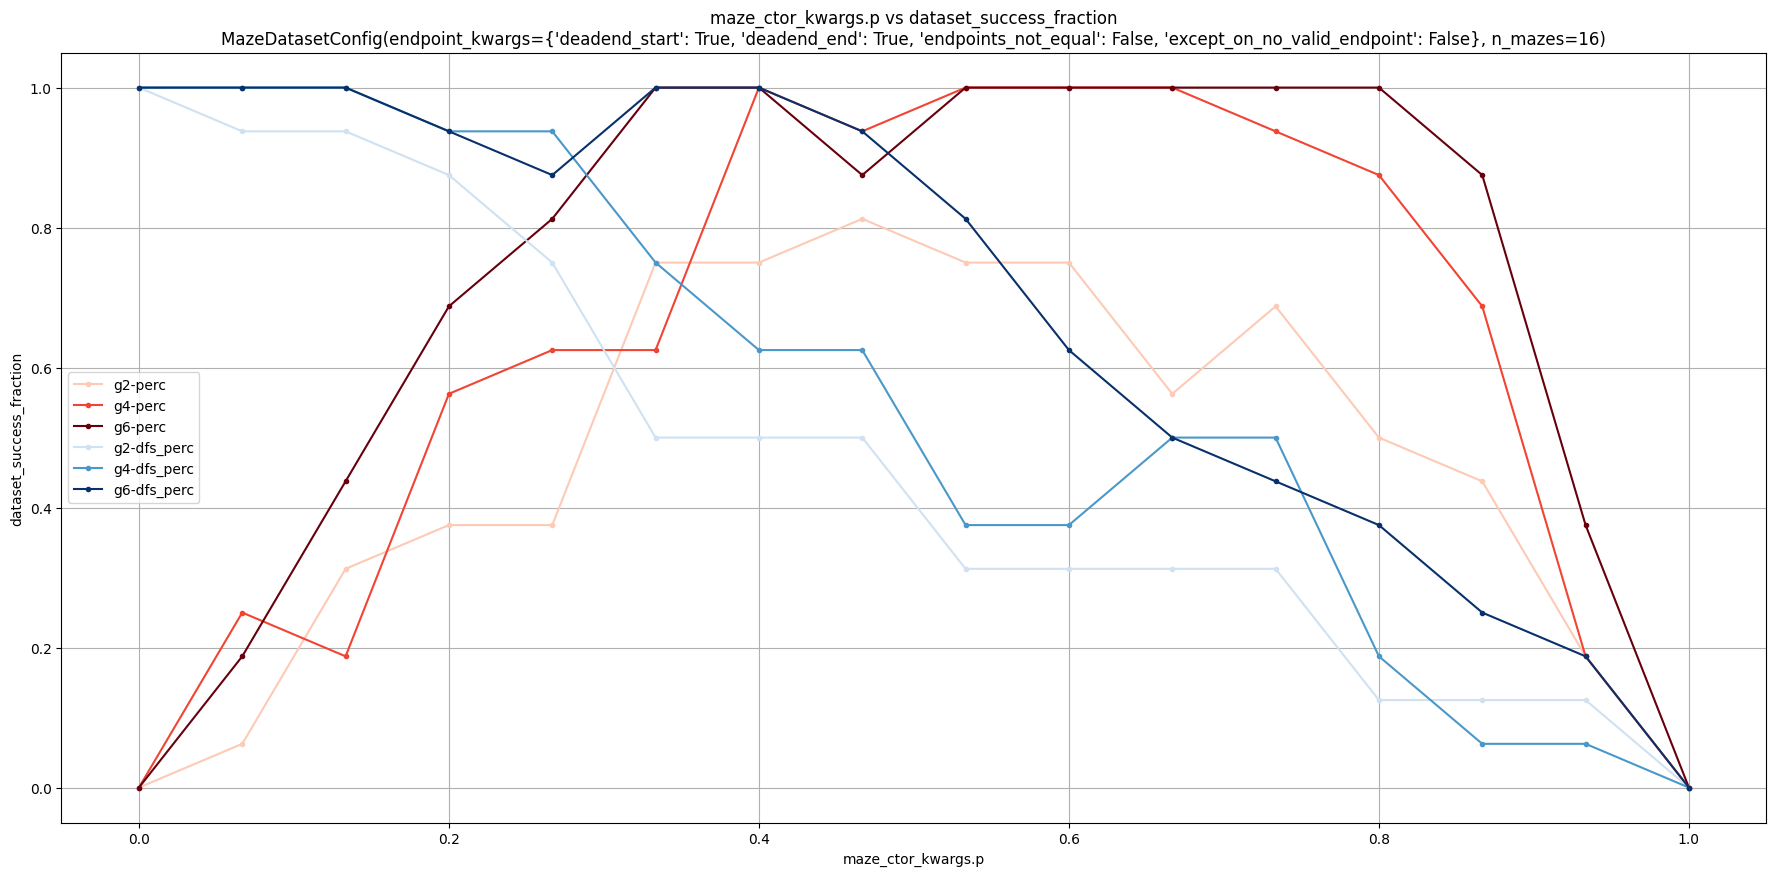

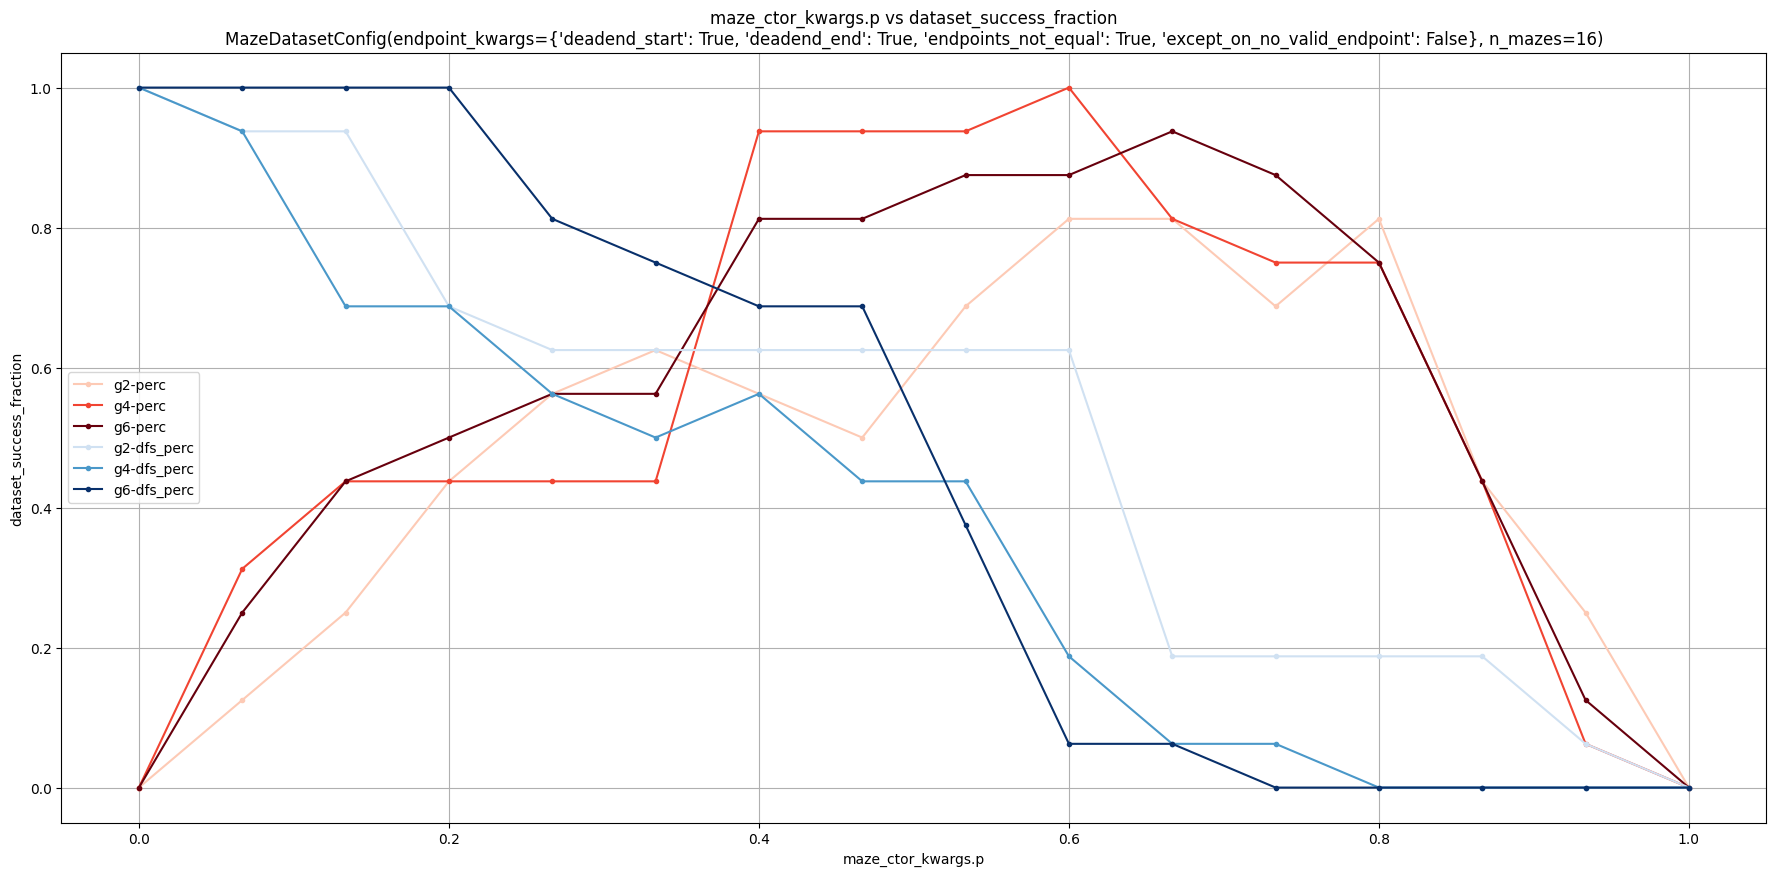

In [6]:
plot_grouped(results_full)

In [7]:
def extract_training_data(
    sweep_result: SweepResult,
) -> tuple[Float[np.ndarray, "num_rows 5"], Float[np.ndarray, " num_rows"]]:
    """Extract data (X, y) from a SweepResult.

    # Parameters:
     - `sweep_result : SweepResult`
        The sweep result holding configs and success arrays.

    # Returns:
     - `X : Float[np.ndarray, "num_rows 5"]`
        Stacked [p, grid_n, deadends, endpoints_not_equal, generator_func] for each config & param-value
     - `y : Float[np.ndarray, "num_rows"]`
        The corresponding success rate
    """
    X_list: list[list[float]] = []
    y_list: list[float] = []
    for cfg in sweep_result.configs:
        # success_arr is an array of success rates for param_values
        success_arr = sweep_result.result_values[cfg.to_fname()]
        for i, p in enumerate(sweep_result.param_values):
            # Temporarily override p in the config's array representation:
            arr = cfg._to_ps_array().copy()
            arr[0] = p  # index 0 is 'p'
            X_list.append(arr)
            y_list.append(success_arr[i])

    return np.array(X_list, dtype=np.float64), np.array(y_list, dtype=np.float64)

In [9]:
DATA_PATH: str = "../docs/benchmarks/percolation_fractions/medium/result-n128-c42-p50.zanj"
# DATA_PATH: str = "../docs/benchmarks/percolation_fractions/small/result-n64-c30-p25.zanj"
# DATA_PATH: str = "../docs/benchmarks/percolation_fractions/test/result-n16-c12-p16.zanj"
RESULTS_LOADED: SweepResult = SweepResult.read(DATA_PATH)

# Convert to arrays
X, y = extract_training_data(RESULTS_LOADED)

print(f"training data extracted: {X.shape = }, {y.shape = }")

# Fit the PySR model
model = PySRRegressor(
    niterations=100,
    # Adjust operators as needed
    unary_operators=[
        "exp",
        "log",
        "inv(x) = 1/x",
        "square(x) = x^2",
        "cube(x) = x^3",
        "sigmoid(x) = 1/(1 + exp(-x))",
    ],
    extra_sympy_mappings={
        "inv": lambda x: 1 / x,
        "square": lambda x: x**2,
        "cube": lambda x: x**3,
        "sigmoid": lambda x: 1 / (1 + sp.exp(-x)),
    },
    binary_operators=["+", "-", "*", "/"],
    # If you want advanced features, specify them here:
    # e.g. select_k_features=4, population_size=1000, etc.
    progress=True,
    model_selection="best",
)
model.fit(X, y)

f:\KNC\maze-dataset\.venv\Lib\site-packages\pysr\sr.py:2780: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 3.500e+04
Progress: 216 / 3100 total iterations (6.968%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.123e-01  1.594e+01  y = 0.67584
3           1.119e-01  1.679e-03  y = sigmoid(sigmoid(x₃))
4           9.350e-02  1.799e-01  y = 1.3299 - sigmoid(x₂)
5           9.262e-02  9.455e-03  y = (2.7552 - x₂) / 3.0919
6           9.174e-02  9.532e-03  y = sigmoid(1.0247 - (x₀ * x₂))
7           8.964e-02  2.315e-02  y = sigmoid(cube(1.1973 - (x₀ * x₂)))
8           8.154e-02  9.476e-02  y = sigmoid((0.69018 - (x₀ * x₂)) * 2.4587)
11          7.436e-02  3.074e-02  y = sigmoid((0.83649 - (x₀ * x₂)) * exp(square(cube(x₄))))
14          7.386e-02  2.241e-03  y = exp(square(x₀) * (0.18962 - x₂)) * sigmoid(exp(cube(x₄...
                                  

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          0.6757783   
	1         0.001679                               sigmoid(sigmoid(x3))   
	2         0.179922                            1.3298639 - sigmoid(x2)   
	3         0.010926                     0.87493247 - (x2 * 0.29866815)   
	4         0.133399                         log(2.3289464 - (x2 * x0))   
	5         0.048826                   log(2.1445994 - (x2 * cube(x0)))   
	6         0.035883                 0.7880575 - square(x2 * (x0 * x4))   
	7         0.312329      ((0.37793848 - (x0 * x2)) * x4) - -0.65352285   
	8         0.057286      sigmoid(x0) + (x4 * (0.39744005 - (x2 * x0)))   
	9         0.059114  sigmoid((2.6975815 - ((x2 * x0) * 3.991443)) *...   
	10        0.194490  ((x4 + (x0 - 0.6265697)) * (0.3950701 - (x2 * ...   
	11        0.099202  sigmoid((x4 + x0) * ((3.5370514 - ((x0 * x2) *...   
	12        0.234907  sigmoid(((((x4 + -0.58468103) + x0) * (0.45164...   
	13        0.120157  sigmoid(log(x1) + (((x4 + (-0.58338493 + x0)) ...   
	14        0.000207  sigmoid(log(x1) + (((0.44734907 - (x0 * square...   
	15        0.027118  sigmoid(log(x1) + (((x4 + (x0 + -0.6082514)) *...   
	16        0.189398  sigmoid((((0.5279833 - (x0 * ((x3 * 0.4152205)...   
	17  >>>>  0.180622  sigmoid(log(x1) + (((x0 + (x4 + -0.6109301)) *...   
	18        0.030751  sigmoid(((0.5073652 - (((x3 * 0.37584242) + x2...   
	19        0.021710  sigmoid((((0.52733696 - (((x3 * 0.4545125) + x...   
	20        0.072678  sigmoid((((0.5389959 - (((x3 * 0.490097) + x2)...   
	21        0.014519  sigmoid(((0.5389959 - ((x2 + (0.490097 * x3)) ...   
	22        0.003805  sigmoid(log(x1 - cube(x2 - (-1.7368988 * -0.82...   
	23        0.021188  sigmoid((((x4 + -0.6535046) + x0) * ((0.510264...   
	
	        loss  complexity  
	0   0.112310           1  
	1   0.111934           3  
	2   0.093502           4  
	3   0.092486           5  
	4   0.080936           6  
	5   0.077079           7  
	6   0.074362           8  
	7   0.054414           9  
	8   0.051384          10  
	9   0.045655          12  
	10  0.037585          13  
	11  0.034036          14  
	12  0.021276          16  
	13  0.018868          17  
	14  0.018864          18  
	15  0.018359          19  
	16  0.015191          20  
	17  0.012681          21  
	18  0.011925          23  
	19  0.011418          25  
	20  0.010617          26  
	21  0.010464          27  
	22  0.010425          28  
	23  0.009992          30  
]

Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe2 in position 4095: unexpected end of data

Best PySR Equation: model.get_best()['equation'] = 'sigmoid(log(x1) + (((x0 + (x4 + -0.6109301)) * 10.794554) * (0.52652115 - (((x3 * 0.40493143) + x2) * x0))))'
predict_fn =PySRFunction(X=>1/(1 + exp(-(-x0*(x2 + 0.40493143*x3) + 0.52652115)*(10.794554*x0 + 10.794554*x4 - 6.5947179546754))/x1))
Best PySR Equation: sigmoid(log(x1) + (((x0 + (x4 + -0.6109301)) * 10.794554) * (0.52652115 - (((x3 * 0.40493143) + x2) * x0))))
Predicted success rate for test_config: 0.918342126071747


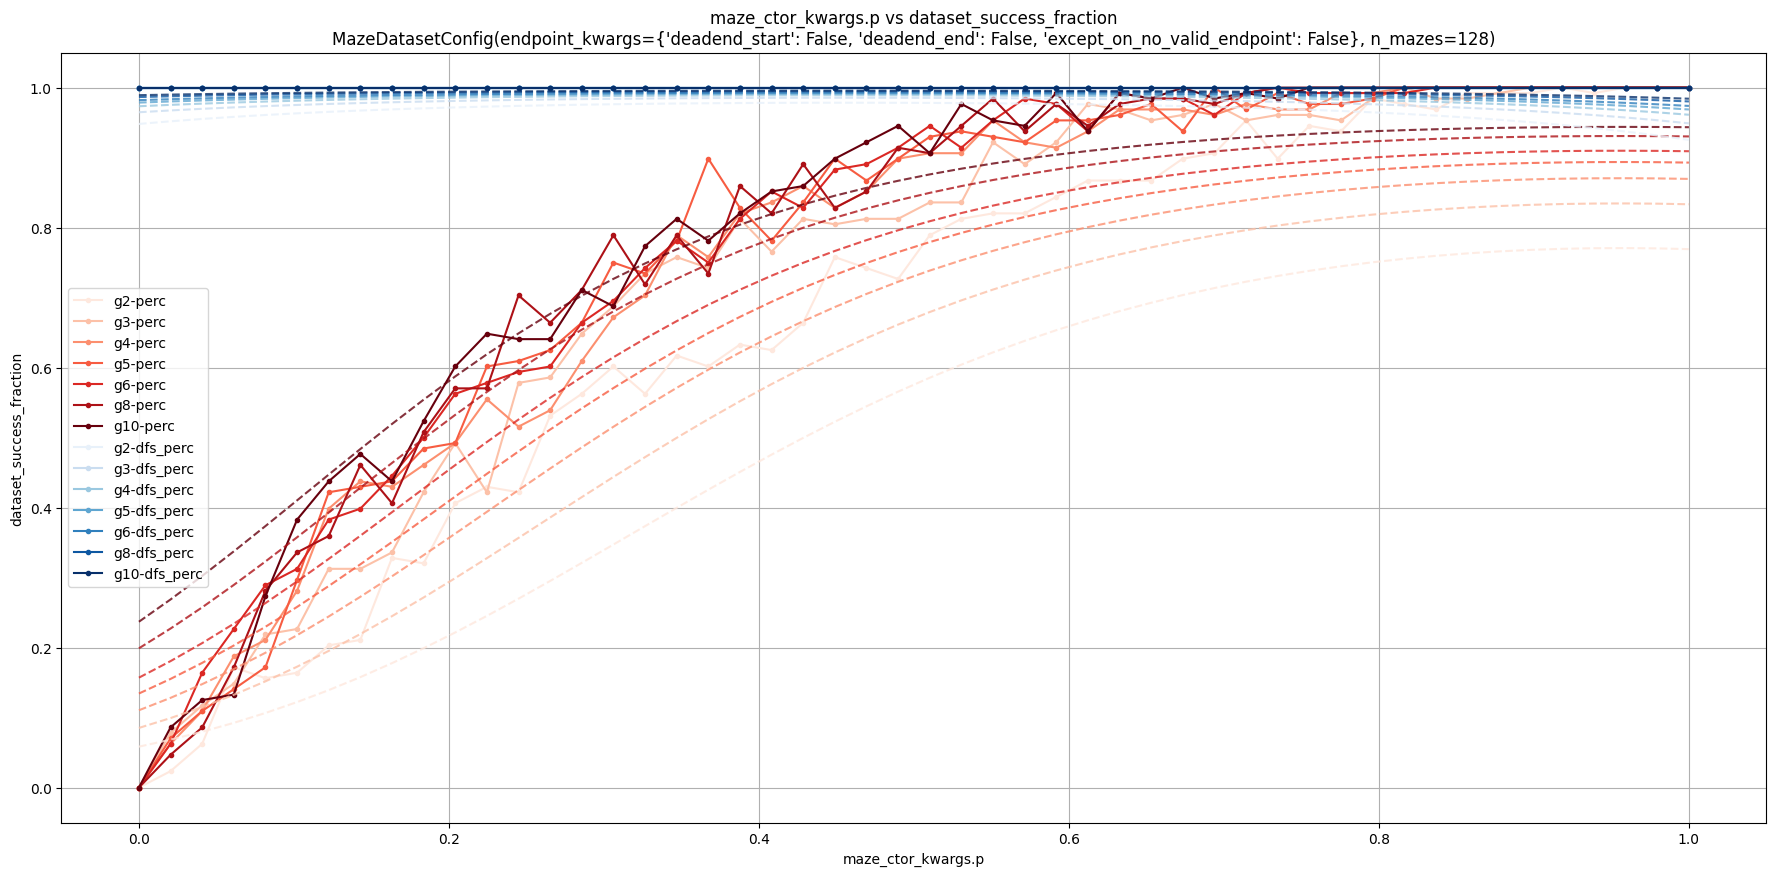

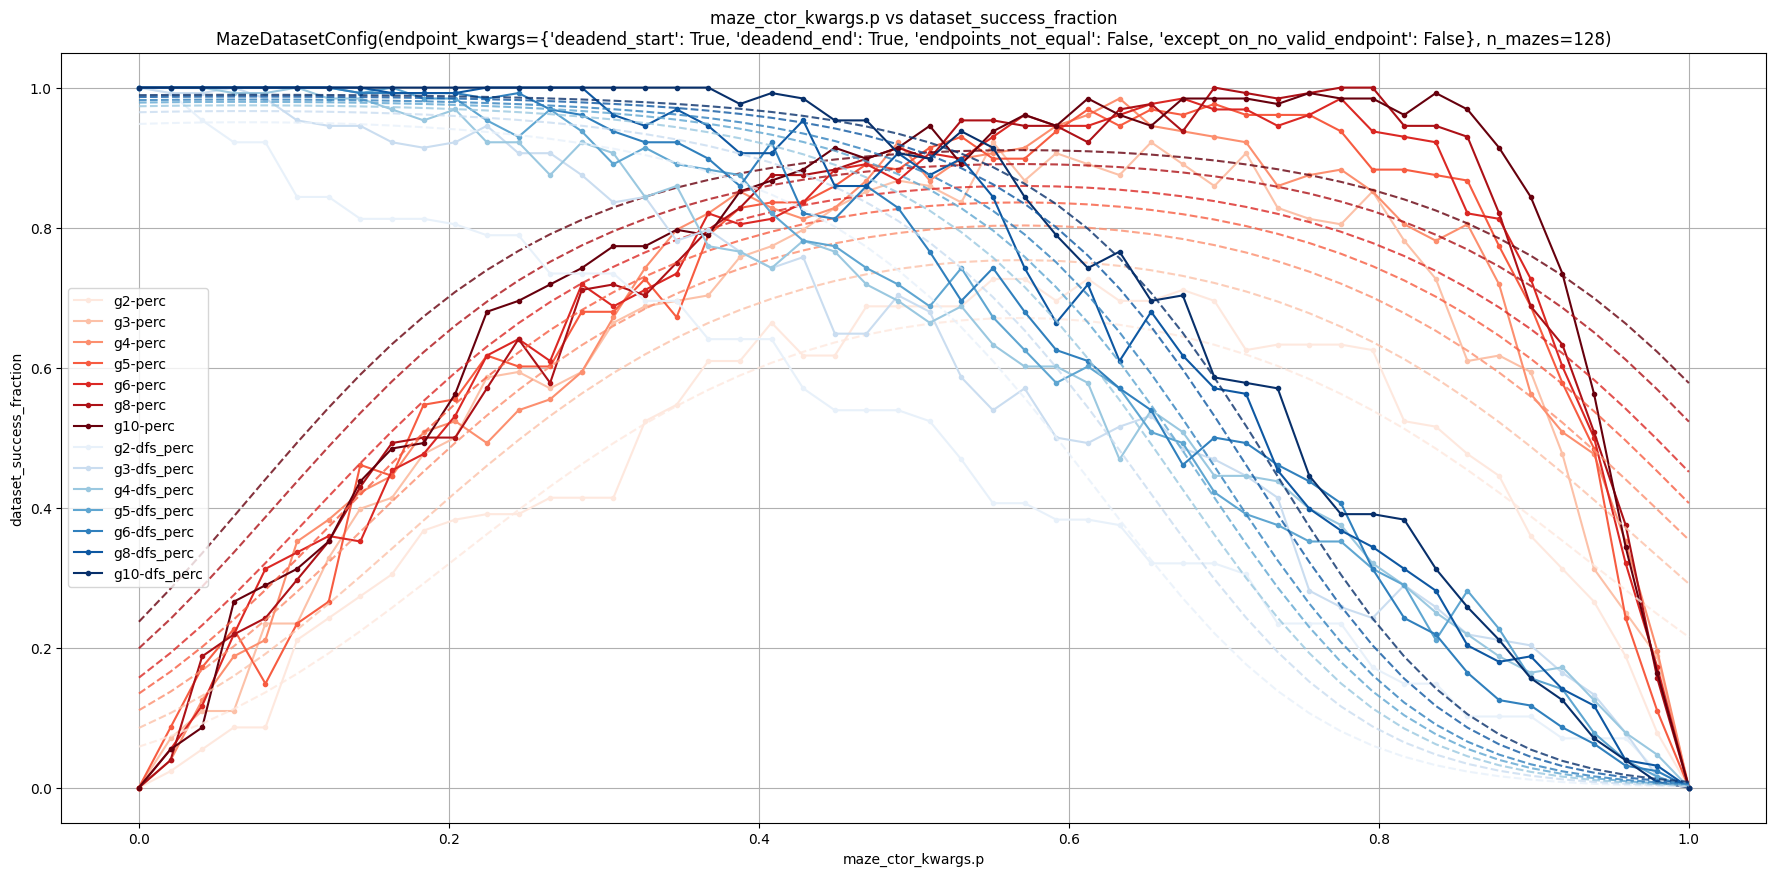

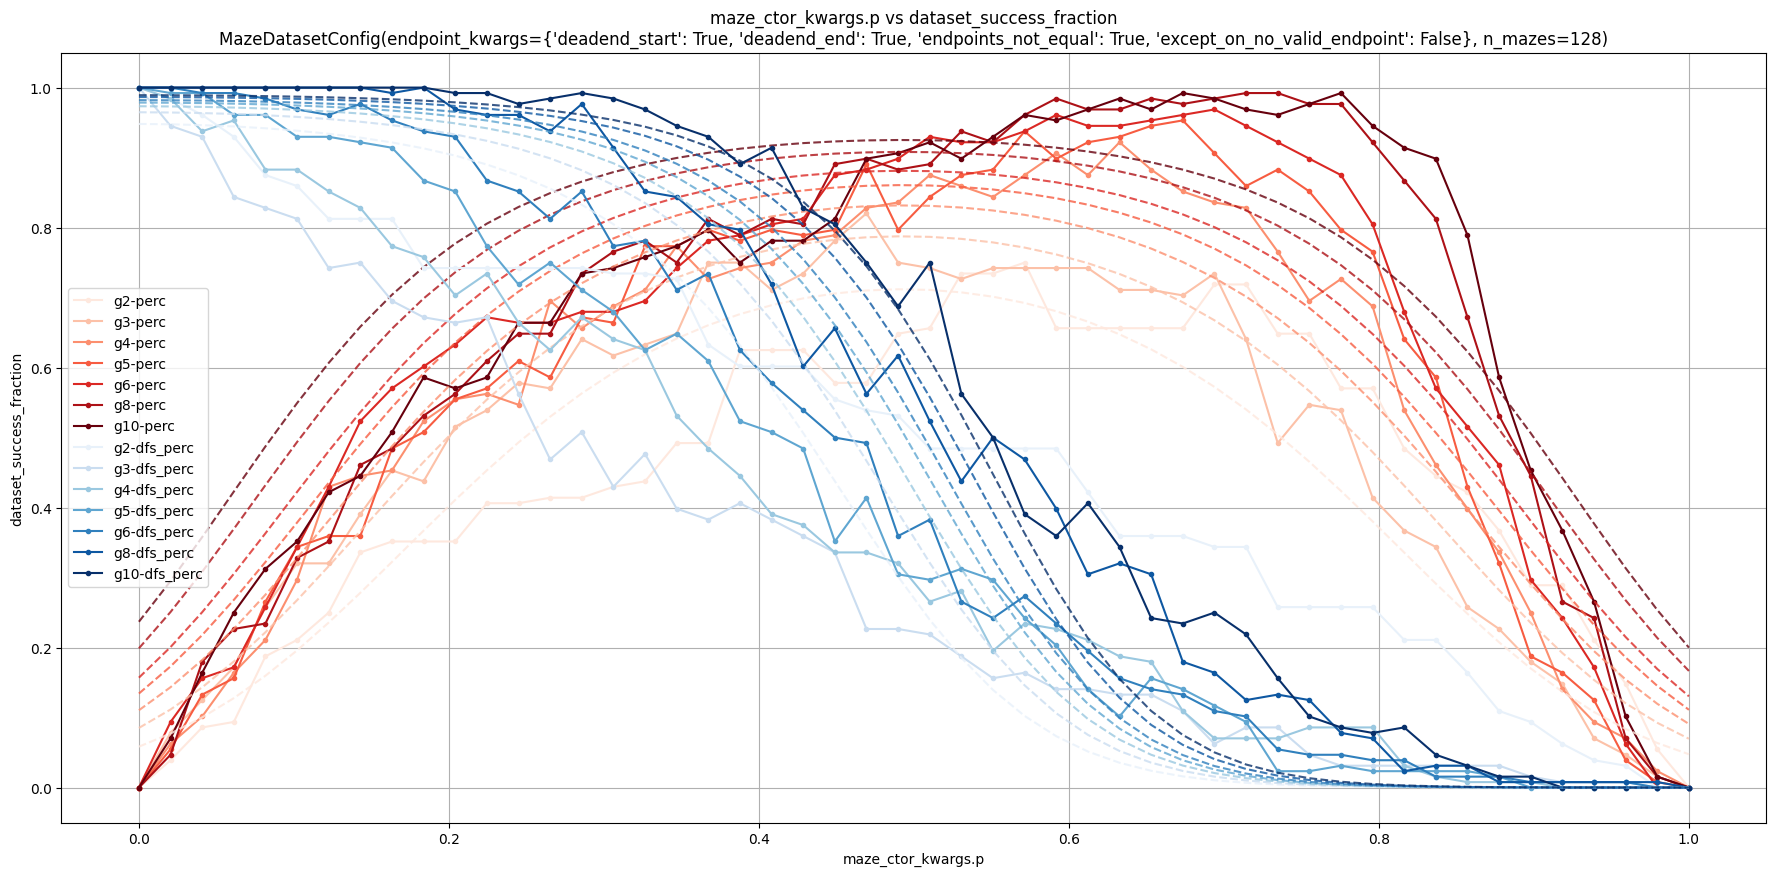

Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe2 in position 4095: unexpected end of data

In [10]:
# Create a callable that predicts from MazeDatasetConfig
predict_fn = model.get_best()["lambda_format"]
print(f"Best PySR Equation: {model.get_best()['equation'] = }")
print(f"{predict_fn =}")


def predict_config(cfg: MazeDatasetConfig) -> float:
    arr = cfg._to_ps_array()
    result = predict_fn(arr)[0]
    return float(result)  # pass the array as separate args


# Example new config
test_config = MazeDatasetConfig(
    name="some_test",
    grid_n=16,
    n_mazes=100,
    maze_ctor=LatticeMazeGenerators.gen_percolation,
    maze_ctor_kwargs={"p": 0.3},
    endpoint_kwargs={
        "deadend_start": True,
        "deadend_end": True,
        "endpoints_not_equal": True,
        "except_on_no_valid_endpoint": False,
    },
)
predicted_rate = predict_config(test_config)
print("Best PySR Equation:", model.get_best()["equation"])
print("Predicted success rate for test_config:", predicted_rate)


plot_grouped(RESULTS_LOADED, predict_fn=predict_config)